#Imports

In [ ]:
# Import Libraries
import numpy as np
import pandas as pd
import sklearn
import json
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
# Import whole database
with open('feature_database.json') as json_database:
    database = json.load(json_database)

#Data Formatting

##Economy

In [ ]:
# Concat data from sector economy
X_eco_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'economy':
        new_data = pd.read_json(database[i]['data'])
        if X_eco_raw is None:
            X_eco_raw = new_data
        else:
            X_eco_raw = pd.concat([X_eco_raw, new_data], axis=1, join="inner")

X_eco_raw.head()

,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
2005-01-01,85.3,5086847,4246.440011,5506.678548,83.5,87.7,79.3,77.7,104.5,1632220,1631127,1093
2005-02-01,85.6,5288245,4344.744019,5737.214453,85.0,83.9,80.5,80.4,99.8,1499439,1497408,2031
2005-03-01,86.0,5266085,4357.401460,5696.047894,98.1,98.3,90.5,89.4,112.1,1550679,1549418,1261
2005-04-01,85.8,5052429,4293.807617,5708.181431,96.3,97.8,99.4,99.0,116.0,1507829,1504132,3697
2005-05-01,85.9,4884238,4329.549139,5751.507302,94.6,94.3,112.7,111.5,122.9,1474656,1471632,3024


In [ ]:
# Make yearly data
X_eco_yearly = X_eco_raw.groupby(by=[X_eco_raw.index.year]).mean()
X_eco_yearly.head()

,ECO_Consumer_Price_Index,ECO_Unemployment_Number,ECO_DAX,ECO_MDAX,ECO_Wholesale_Turnover,ECO_Retail_Sales,ECO_Accommodation,ECO_Hotels_Inns_Guesthouses,ECO_Gastronomy,FuelSale_rohbenzin_tons_insg,FuelSale_rohbenzin_tons_chemWeiterVera,FuelSale_rohbenzin_tons_sonstige
2005,86.200000,4.860909e+06,4673.969119,6320.411801,95.766667,96.541667,101.616667,100.791667,116.641667,1.502026e+06,1.497219e+06,4806.583333
2006,87.575000,4.487304e+06,5894.782315,8323.640778,98.900000,96.825000,104.000000,103.350000,115.125000,1.418054e+06,1.414380e+06,3674.500000
2007,89.591667,3.760586e+06,7467.005974,10276.417576,99.016667,95.575000,104.725000,104.200000,112.883333,1.392416e+06,1.375512e+06,16903.333333
2008,91.941667,3.258954e+06,6203.415794,7963.720729,103.225000,95.625000,103.241667,102.558333,109.241667,1.312076e+06,1.285732e+06,26344.250000
2009,92.216667,3.414992e+06,5016.015516,6060.038900,93.025000,92.625000,94.250000,93.266667,101.566667,1.269730e+06,1.237553e+06,32177.500000


##Mobility

In [ ]:
# Concat data from sector mobility
X_mob_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'mobility':
        new_data = pd.read_json(database[i]['data'])
        if X_mob_raw is None:
            X_mob_raw = new_data
        else:
            X_mob_raw = pd.concat([X_mob_raw, new_data], axis=1, join="inner")

X_mob_raw.head()

,M_KFZ,M_SV,M_LV,FuelSale_tons_ottokraftstoff_insg,FuelSale_tons_ottokraftstoff_militaer,FuelSale_tons_ottokraftstoff_sonstige,FuelSale_tons_dieselkraftstoff_insg,FuelSale_tons_dieselkraftstoff_schifffahrt,FuelSale_tons_dieselkraftstoff_militaer,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_flugkraftstoff_schwer_insg,FuelSale_tons_flugkraftstoff_schwer_luftfahrt,FuelSale_tons_flugkraftstoff_schwer_militaer,FuelSale_tons_flugkraftstoff_schwer_sonstige,M_AviationTotalStartsAndLandings,M_InlandShippingTotalTransportPerformance,M_ShipsGermanFlag,M_ShipsForeignFlag,M_TotalRailFreights
2011-01-01,9.163182e+05,169467.115962,750949.929440,1519000,9157,1509843,2311195,11934,1254,2298007,629657,577369,8650,43638,157923.0,3189,2290912,21139202,8076598488
2011-02-01,9.228540e+05,180239.437819,749058.876655,1427494,8848,1418646,2443433,13238,1263,2428932,579036,522739,13632,42665,156000.0,4363,2029008,17342809,8921846067
2011-03-01,1.016968e+06,213801.934974,810814.414153,1625129,9612,1615517,2823922,16720,1523,2805679,671266,615881,13563,41822,181547.0,5462,2207955,19158437,10551559425
2011-04-01,9.952840e+05,191174.978164,807489.501513,1617986,9745,1608241,2651636,15382,1305,2634949,691378,631931,13229,46218,178565.0,4543,2198525,18988716,9301455105
2011-05-01,1.032499e+06,216044.506250,823418.977051,1789329,9870,1779459,2917399,17289,1080,2899030,738227,670475,15654,52098,198289.0,4326,2784340,20470142,10658822441


In [ ]:
# Make yearly data
X_mob_yearly = X_mob_raw.groupby(by=[X_mob_raw.index.year]).mean()
X_mob_yearly.head()

,M_KFZ,M_SV,M_LV,FuelSale_tons_ottokraftstoff_insg,FuelSale_tons_ottokraftstoff_militaer,FuelSale_tons_ottokraftstoff_sonstige,FuelSale_tons_dieselkraftstoff_insg,FuelSale_tons_dieselkraftstoff_schifffahrt,FuelSale_tons_dieselkraftstoff_militaer,FuelSale_tons_dieselkraftstoff_sonstige,FuelSale_tons_flugkraftstoff_schwer_insg,FuelSale_tons_flugkraftstoff_schwer_luftfahrt,FuelSale_tons_flugkraftstoff_schwer_militaer,FuelSale_tons_flugkraftstoff_schwer_sonstige,M_AviationTotalStartsAndLandings,M_InlandShippingTotalTransportPerformance,M_ShipsGermanFlag,M_ShipsForeignFlag,M_TotalRailFreights
2011,1.016995e+06,196584.485633,823443.379058,1.633427e+06,9354.500000,1.624072e+06,2.746984e+06,15661.083333,1296.916667,2.730026e+06,681910.833333,630035.750000,8010.250000,43864.833333,180954.833333,4585.666667,2.339703e+06,1.919923e+07,9.429982e+09
2012,1.021217e+06,197812.908559,826417.456419,1.540570e+06,8344.166667,1.532226e+06,2.806496e+06,19097.000000,2024.500000,2.785374e+06,723770.500000,641221.250000,2279.750000,80269.500000,176259.083333,4873.833333,2.099412e+06,1.948743e+07,9.172067e+09
2013,1.017446e+06,198160.653371,822703.103219,1.535189e+06,8166.916667,1.527022e+06,2.903369e+06,15364.583333,1407.583333,2.886596e+06,733488.666667,646299.666667,3990.250000,83198.750000,169086.083333,5005.833333,2.109805e+06,1.954990e+07,9.221209e+09
2014,1.094470e+06,205703.833609,887831.153395,1.543886e+06,7378.583333,1.536508e+06,2.965590e+06,15555.583333,1426.000000,2.948608e+06,710506.000000,594520.583333,5957.416667,110028.000000,167786.250000,4924.333333,2.040195e+06,2.115284e+07,9.385734e+09
2015,1.114131e+06,212537.860307,900861.979225,1.518840e+06,6864.666667,1.511976e+06,3.063033e+06,18453.666667,1201.083333,3.043378e+06,711404.500000,599208.833333,7255.500000,104940.166667,168997.250000,4609.500000,1.852702e+06,2.067643e+07,9.528410e+09


##Energy and households

In [ ]:
# Concat data from sector engergy and households
X_eh_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'energy_households':
        new_data = pd.read_json(database[i]['data'])
        if X_eh_raw is None:
            X_eh_raw = new_data
        else:
            X_eh_raw = pd.concat([X_eh_raw, new_data], axis=1, join="inner")

X_eh_raw.head()

,CO2 of Coal-Energy in (Tonnen),CO2 of Gas in (Tonnen),CO2 of Biomass (Tonnen),CO2 of Hydropower (Tonnen),CO2 of Nuclear (Tonnen),heating_oil_price_in_usd,Deutschland,Deutschland,Deutschland
2007-03-01,20301552.62,2671491.27,355149.122723,49267.728,163265.172,66.790,6.18,63.3,159.6
2007-04-01,18090427.54,2235436.84,334754.479104,39440.736,141627.708,66.350,11.52,4.0,288.8
2007-05-01,17809621.82,2153908.19,356708.400428,47210.808,142169.232,66.615,14.16,131.1,221.6
2007-06-01,17625316.98,2120555.85,333615.733871,53689.536,133340.388,67.545,17.38,108.6,195.2
2007-07-01,18217962.96,1992911.34,368314.387891,55829.616,118069.584,67.335,17.24,121.3,192.3


In [ ]:
# Make yearly data
X_eh_yearly = X_eh_raw.groupby(by=[X_eh_raw.index.year]).mean()
X_eh_yearly

,CO2 of Coal-Energy in (Tonnen),CO2 of Gas in (Tonnen),CO2 of Biomass (Tonnen),CO2 of Hydropower (Tonnen),CO2 of Nuclear (Tonnen),heating_oil_price_in_usd,Deutschland,Deutschland,Deutschland
2007,1.921117e+07,2.514352e+06,354145.239261,49346.2488,136584.9996,67.650367,10.953000,79.550000,159.200000
2008,1.794701e+07,2.967292e+06,395429.249350,46007.2420,148495.2460,75.708540,9.479167,64.866667,136.233333
2009,1.660987e+07,2.528093e+06,423819.907500,42889.1880,134932.0340,44.375692,9.177500,67.725000,140.491667
2010,1.711307e+07,2.810917e+06,463416.630833,47260.1960,140556.4530,56.918059,7.845833,72.383333,128.183333
2011,1.716080e+07,2.669257e+06,483730.537500,41092.5500,107971.2300,78.219067,9.635000,61.075000,153.941667
2012,1.843625e+07,2.143114e+06,488748.082421,48769.4260,99460.1990,79.991456,9.086667,63.958333,139.466667
2013,1.893386e+07,1.710482e+06,516417.780301,46313.6220,97290.0380,79.202250,8.714167,64.883333,125.641667
2014,1.841147e+07,1.371645e+06,577900.441463,43608.2160,97129.2770,73.237788,10.326667,60.583333,135.083333
2015,1.495723e+07,4.224048e+05,665415.779167,45507.7820,84360.3370,43.769422,9.939167,58.433333,145.225000
2016,1.433784e+07,9.576677e+05,757930.116667,53853.4980,79577.0680,35.980047,9.548333,61.100000,133.950000


##Target Values

In [ ]:
# Concat data from target values
Y_raw = None 
for i in database:
    feature = database.get(i)
    if feature['sector'] == 'target_values':
        new_data = pd.read_json(database[i]['data'])
        if Y_raw is None:
            Y_raw = new_data
        else:
            Y_raw = pd.concat([Y_raw, new_data], axis=1, join="inner")

Y_raw.head()

,E_Mio.tonnes_CO2,M_Mio.tonnes_CO2,ECO_Mio.tonnes_CO2
1990,598.311813,163.164356,349.258950
1991,585.075308,166.069919,324.291221
1992,551.657084,172.055024,306.679658
1993,552.341605,176.430513,294.613034
1994,540.816095,172.511450,294.161646


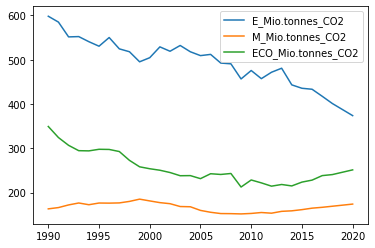

In [ ]:
Y_raw.plot()

#Mapping

In [ ]:
Y = Y_raw[(Y_raw.index <= 2017)]
Y_oeko_estimate = Y_raw[(Y_raw.index > 2017) & (Y_raw.index <= 2020)]

##Economy

In [ ]:
Y_eco_train = Y[['ECO_Mio.tonnes_CO2']][(Y.index >= X_eco_yearly.index.min())]

X_eco_yearly_train = X_eco_yearly[(X_eco_yearly.index <=2017)]
X_eco_yearly_future = X_eco_yearly[(X_eco_yearly.index >2017)]

###Model 1: Linear/Non-Linear Regression

Best parameter RMSE=4.596):
{'pca__n_components': 8}


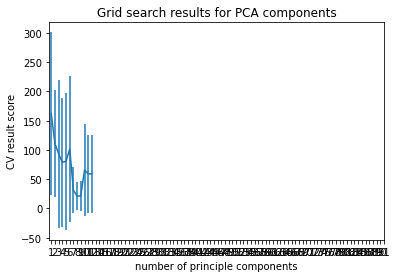

RMSE training fit: 1.092
R2 training fit: 0.989 


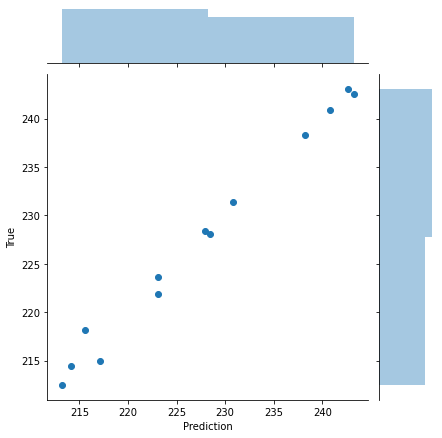

In [ ]:
poly = PolynomialFeatures(degree=2)
X_train = poly.fit_transform(X_eco_yearly_train)

### Scaling
scaler = StandardScaler()
#scaler = RobustScaler()
#scaler = MinMaxScaler()

# PCA
pca = PCA()

### Validation
cval = LeaveOneOut() 
#cval = KFold(n_splits=2)

### Estimator
estimator = LinearRegression()
# estimator = Ridge(alpha = 0.5)
# estimator = Lasso(alpha = 0.1)

pipe = Pipeline(steps=[('scaler',scaler),('pca', pca), ('estimator', estimator)])
param_grid = {'pca__n_components': range(1,X_train.shape[1]+1)}

### GridSearch
search = GridSearchCV(pipe, param_grid, n_jobs=-1,cv=cval,scoring='neg_mean_squared_error',return_train_score=True)
search.fit(X_train, Y_eco_train)
print("Best parameter RMSE=%0.3f):" % np.sqrt(-search.best_score_))
print(search.best_params_)

plt.figure()
plt.errorbar(range(1,X_train.shape[1]+1),-search.cv_results_['mean_test_score'],yerr=search.cv_results_['std_test_score'])
#plt.plot(range(1,X_train.shape[1]+1),-search.cv_results_['mean_train_score'])
plt.xticks(range(1,X_train.shape[1]+1))
plt.xlabel("number of principle components")
plt.ylabel("CV result score")
plt.title("Grid search results for PCA components")
plt.show()

best_estimator = search.best_estimator_
y_pred_train = best_estimator.predict(X_train)

print("RMSE training fit: %.03f" %np.sqrt(mean_squared_error(Y_eco_train,y_pred_train)))
print("R2 training fit: %.03f " %r2_score(Y_eco_train,y_pred_train))
#print("RMSE prediction: %.03f" %np.sqrt(mean_squared_error(y_test,y_pred_test)))
#print("R2 prediction: %.03f " %r2_score(y_test,y_pred_test))

# predicted/actual plot for test set
ax = sns.jointplot(x=y_pred_train,y=Y_eco_train)
ax.ax_joint.set_xlabel('Prediction')
ax.ax_joint.set_ylabel('True')
plt.show()

In [ ]:
Y_eco_yearly_pred_future = best_estimator.predict(poly.fit_transform(X_eco_yearly_future))
print(Y_eco_yearly_pred_future)
print(Y_oeko_estimate[['ECO_Mio.tonnes_CO2']])

[[247.08994936]
 [247.75264091]
 [263.16900805]]
      ECO_Mio.tonnes_CO2
2018          240.610095
2019          245.934208
2020          251.258321


###Model 2: Neuronal Network

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_eco_yearly_train)
X_eco_yearly_train = scaler.transform(X_eco_yearly_train)
X_eco_yearly_future = scaler.transform(X_eco_yearly_future)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_eco_yearly_train, Y_eco_train, test_size=.2)

In [ ]:
network = models.Sequential()
network.add(layers.Dense(2, activation='relu', input_shape=(len(X_train[0]),)))
#network.add(layers.Dense(2, activation='relu'))
network.add(layers.Dense(1))
network.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 2)                 26        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 29
Trainable params: 29
Non-trainable params: 0
_________________________________________________________________


In [ ]:
network.compile(optimizer=optimizers.RMSprop(lr=0.01),
              loss='mean_squared_error',
              metrics=['mse'])

In [ ]:
history = network.fit(X_train, Y_train, batch_size=1, epochs=500, validation_data=(X_val,Y_val))

Train on 10 samples, validate on 3 samples
Epoch 1/500
10/10 [==============================] - 0s 2ms/step - loss: 40.5566 - mse: 40.5566 - val_loss: 76.4383 - val_mse: 76.4383
Epoch 2/500
10/10 [==============================] - 0s 1ms/step - loss: 38.6432 - mse: 38.6432 - val_loss: 76.2514 - val_mse: 76.2514
Epoch 3/500
10/10 [==============================] - 0s 1ms/step - loss: 37.3080 - mse: 37.3080 - val_loss: 70.1214 - val_mse: 70.1214
Epoch 4/500
10/10 [==============================] - 0s 2ms/step - loss: 36.8946 - mse: 36.8946 - val_loss: 68.5995 - val_mse: 68.5995
Epoch 5/500
10/10 [==============================] - 0s 2ms/step - loss: 37.5321 - mse: 37.5321 - val_loss: 73.4712 - val_mse: 73.4712
Epoch 6/500
10/10 [==============================] - 0s 1ms/step - loss: 36.0499 - mse: 36.0499 - val_loss: 73.5337 - val_mse: 73.5337
Epoch 7/500
10/10 [==============================] - 0s 2ms/step - loss: 35.1626 - mse: 35.1626 - val_loss: 68.1833 - val_mse: 68.1833
Epoch 8/500


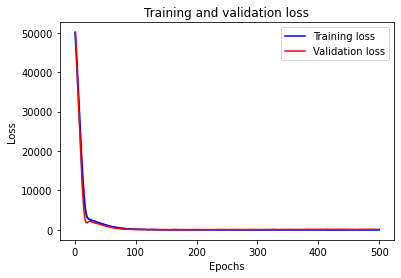

In [ ]:
mse = history.history['mse'] #TO DO: take from the history dictionary of the model the training accuracy
val_mse =  history.history['val_mse'] #TO DO: take from the history dictionary of the model the validation accuracy
loss =  history.history['loss'] #TO DO: take from the history dictionary of the model the training loss
val_loss =  history.history['val_loss'] #TO DO: take from the history dictionary of the model the validation loss 

epochs = range(1, len(mse) + 1)

# Plot the Loss
plt.plot(loss)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'b', label='Training loss') 
# b is for "solid blue line"
plt.plot(epochs,  val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

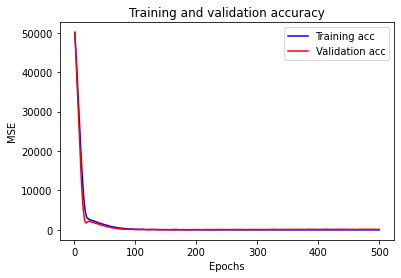

In [ ]:
# Plot the MSE

plt.clf()   # clear figure
acc_values =  mse
val_acc_values =  val_mse

# Plot Epochs vs Training accuracy and Epochs vs Validation accuracy
plt.plot(epochs, mse,  'b', label='Training acc')  
plt.plot(epochs, val_mse, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [ ]:
Y_eco_yearly_pred_future = network.predict(X_eco_yearly_future)

print(Y_eco_yearly_pred_future)
print(Y_oeko_estimate[['ECO_Mio.tonnes_CO2']])
# evaluate
#loss, mse = network.evaluate(X_eco_yearly_train, Y_eco_train)
#print("Loss: %f" %loss)
#print('MSE: %f' %mse)


[[289.43573]
 [299.16464]
 [397.497  ]]
      ECO_Mio.tonnes_CO2
2018          240.610095
2019          245.934208
2020          251.258321


##Mobility

###Model 1: Linear/Non-Linear Regression

###Model 2: Neuronal Network